[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


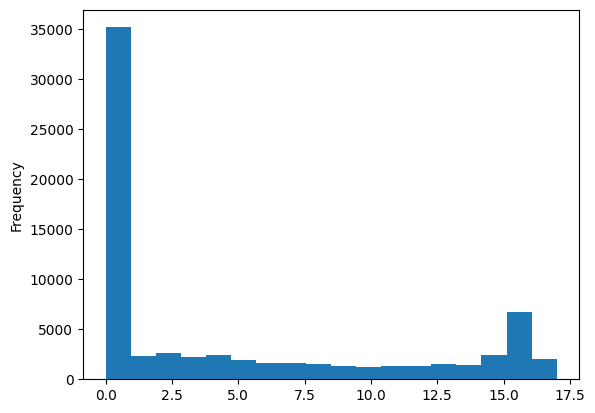

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


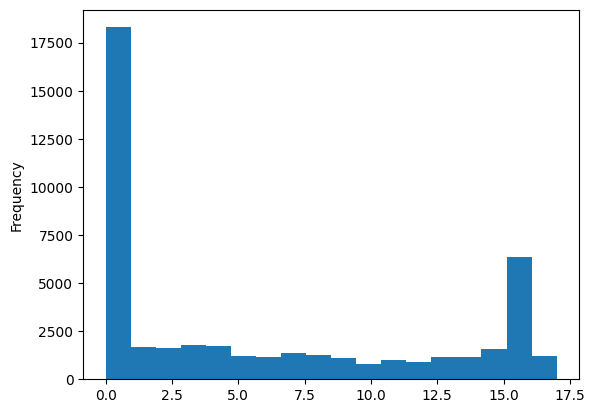

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


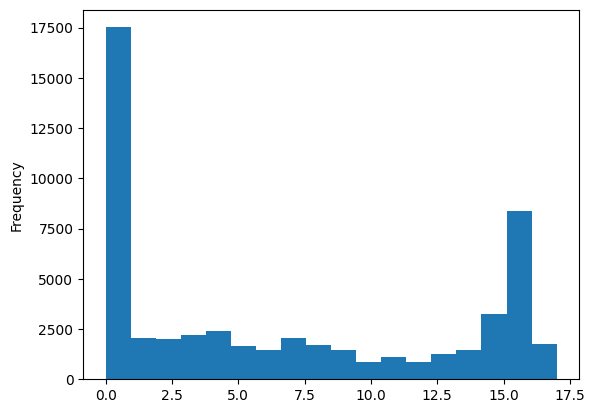

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


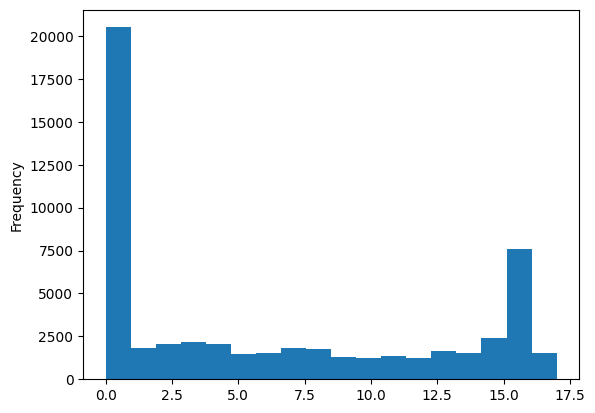

In [59]:
# read each file in datasets/Opportunity/by_subject:

import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

directory = 'datasets/Opportunity/by_subject'
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

for file in csv_files:
    # print(df.columns)
    file_path = os.path.join(directory, file)
    # Process the CSV file as needed
    # For example, you can use pandas to read the CSV file:
    df = pd.read_csv(file_path)
    
    # print(df.to_numpy()[0:6])
    # print(df.to_numpy()[:, 9])
    
    # data statistics in plt:
    print(np.unique(df['ML_Both_Arms']))
    df['ML_Both_Arms'].plot(kind='hist', bins=18)
    plt.show()


In [60]:
from utilities import *
sw = sliding_windows(50, 25)
X = []
Y = []
for file in csv_files:
    # print(df.columns)
    file_path = os.path.join(directory, file)
    # Process the CSV file as needed
    # For example, you can use pandas to read the CSV file:
    df = pd.read_csv(file_path)
    
    x, y = sw(torch.tensor(df.to_numpy()[:, 0:6]), torch.tensor(df.to_numpy()[:, 9]))
    print(x.shape, torch.unique(y, dim=1).shape)
    X.append(x)
    Y.append(torch.unique(y, dim=1))

X = torch.cat(X, dim=0)
Y = torch.cat(Y, dim=0)
X.shape, Y.shape


torch.Size([2836, 50, 6]) torch.Size([2836, 1])
torch.Size([1817, 50, 6]) torch.Size([1817, 1])
torch.Size([2134, 50, 6]) torch.Size([2134, 1])
torch.Size([2197, 50, 6]) torch.Size([2197, 1])


(torch.Size([8984, 50, 6]), torch.Size([8984, 1]))

In [79]:
from sklearn.discriminant_analysis import StandardScaler
import torch
from torch.utils.data import Dataset

class MultivariateTimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

def ss_transform_fit(ss: StandardScaler, data: torch.Tensor):
    # Reshape the data to 2D
    n_samples, n_time_steps, n_features = data.shape
    data_reshaped = data.reshape(-1, n_features)  # The shape becomes (n_samples * n_time_steps, n_features)
    # Fit and transform the data
    scaled_data_reshaped = ss.fit_transform(data_reshaped)

    # Reshape the scaled data back to 3D
    scaled_data = scaled_data_reshaped.reshape(n_samples, n_time_steps, n_features)
    return scaled_data

def ss_transform(ss: StandardScaler, data: torch.Tensor):
    # Reshape the data to 2D
    n_samples, n_time_steps, n_features = data.shape
    data_reshaped = data.reshape(-1, n_features)  # The shape becomes (n_samples * n_time_steps, n_features)
    # Fit and transform the data
    scaled_data_reshaped = ss.transform(data_reshaped)

    # Reshape the scaled data back to 3D
    scaled_data = scaled_data_reshaped.reshape(n_samples, n_time_steps, n_features)
    return scaled_data

# Create an instance of the MultivariateTimeSeriesDataset
dataset = MultivariateTimeSeriesDataset(X, Y)

# Dataloader
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
train_X, test_X, train_Y, test_Y = train_test_split(dataset.X, dataset.Y, test_size=0.2, random_state=42)


# Initialize the StandardScaler
scaler = StandardScaler()

train_X = ss_transform_fit(scaler, train_X)
test_X = ss_transform(scaler, test_X)



# Create dataloaders for train and test sets
train_dataloader = DataLoader(MultivariateTimeSeriesDataset(train_X, train_Y), batch_size=32, shuffle=True)
test_dataloader = DataLoader(MultivariateTimeSeriesDataset(test_X, test_Y), batch_size=32, shuffle=False)


In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
num_epochs = 10

import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=6, hidden_size=1024, num_layers=2, output_size=18):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Create an instance of the CNN model
model = LSTMModel()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Iterate over the training data
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # Forward pass
        outputs = model(images.float())
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # train loss and accuracy check:
        if i % 1000 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            print('Accuracy: {:.2f}%'.format(correct / total * 100))

# Evaluate the model on the test data
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print('Test Accuracy: {:.2f}%'.format(accuracy))


Epoch [1/10], Loss: 2.8847
Accuracy: 25.00%
Epoch [2/10], Loss: 1.1525
Accuracy: 34.38%
Epoch [3/10], Loss: 1.2393
Accuracy: 40.62%
Epoch [4/10], Loss: 0.6014
Accuracy: 81.25%
Epoch [5/10], Loss: 0.1440
Accuracy: 96.88%
Epoch [6/10], Loss: 0.2790
Accuracy: 90.62%
Epoch [7/10], Loss: 0.0804
Accuracy: 96.88%
Epoch [8/10], Loss: 0.0116
Accuracy: 100.00%
Epoch [9/10], Loss: 0.0836
Accuracy: 93.75%
Epoch [10/10], Loss: 0.0055
Accuracy: 100.00%


ValueError: input must have the type torch.float32, got type torch.float64